In [2]:
import nltk
import h5py
import pandas as pd
import numpy as np
import re
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import sys
from nltk.corpus import wordnet
from nltk import pos_tag

from numpy import triu
from gensim.models.doc2vec import Doc2Vec, TaggedDocument


In [4]:
# Hide deprecated warnings of sklearn package
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

# code Initialization

In [17]:
true_csv_path = '/content/true.csv'
fake_csv_path = '/content/fake.csv'

true_df = pd.read_csv(true_csv_path)
fake_df = pd.read_csv(fake_csv_path)

true_df['label'] = '0'
fake_df['label'] = '1'

true_df.to_csv(true_csv_path, index=False)
fake_df.to_csv(fake_csv_path, index=False)


In [18]:
true_df.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",0


In [19]:
fake_df.head()

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1


In [20]:
# Merge DataFrames
merged_df = pd.concat([true_df, fake_df], ignore_index=True)

merged_df = merged_df.sample(frac=1).reset_index(drop=True) #randomized

merged_csv_path = 'merged.csv'
merged_df.to_csv(merged_csv_path, index=False)

print(f'Merged file saved to: {merged_csv_path}')

Merged file saved to: merged.csv


In [21]:
merge_csv_path = 'merged.csv'
df = pd.read_csv(merge_csv_path)

# Data cleaning

1.1.	Removing HTML tags or unwanted characters
    1.1.1.	Eliminating special characters, punctuation
    1.1.2.	remove common English stopwords.
1.2.	Converting text to lowercase
1.3.	finding rows with missing values
    1.3.1.	Filling missing values with a placeholder
    1.3.2.	Imputing missing values
    1.3.3.	Removing rows with unnecessary missing values
1.4.	Text Length (Characters)
    1.4.1.	Word Count:


In [22]:
# Function to clean text
def clean_text(text):
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove punctuation and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert text to lowercase
    text = text.lower().strip()
    return text

df['cleaned_title'] = df['title'].apply(clean_text)
df['cleaned_text'] = df['text'].apply(clean_text)

In [23]:
# Download the stopwords dataset if not already downloaded
nltk.download('stopwords')
# Download the Punkt sentence tokenizer model
nltk.download('punkt')

# Load stop words
stop_words = set(stopwords.words('english'))

# Function to remove stop words
def remove_stop_words(text):
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word not in stop_words]
    return ' '.join(filtered_text)


df['cleaned_title_no_stopwords'] = df['cleaned_title'].apply(remove_stop_words)
df['cleaned_text_no_stopwords'] = df['cleaned_text'].apply(remove_stop_words)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [24]:
df.drop(['cleaned_text', 'cleaned_title',], axis=1, inplace=True)
df.head()

,title,text,subject,date,label,cleaned_title_no_stopwords,cleaned_text_no_stopwords
0,OUTRAGE! HOW REFUGEE RESETTLEMENT Is Using Uni...,Admitting Somalis who d been settled for year...,politics,"Dec 9, 2016",1,outrage refugee resettlement using united stat...,admitting somalis settled years pakistan like ...
1,ARMY THREATENS GREEN BERET WAR HERO WITH COURT...,The Army can t be bothered with defending or p...,left-news,"Jun 12, 2015",1,army threatens green beret war hero court mart...,army bothered defending protecting war heroes ...
2,Bill Maher Hilariously Hammers ‘Evil’ Ted Cru...,Jimmy Kimmel couldn t stop laughing as Bill Ma...,News,"February 10, 2016",1,bill maher hilariously hammers evil ted cruz j...,jimmy kimmel stop laughing bill maher repeated...
3,BREAKING: PRESIDENT-ELECT TRUMP Meets With Pre...,"Obama: Time for us to come together, work toge...",politics,"Nov 10, 2016",1,breaking presidentelect trump meets president ...,obama time us come together work together deal...
4,"As Catalan vote looms, jailed leader offers ol...",MADRID/BARCELONA (Reuters) - The jailed leader...,worldnews,"December 18, 2017",0,catalan vote looms jailed leader offers olive ...,madridbarcelona reuters jailed leader cataloni...


## Steemming

In [25]:
#stemming
# Initialize the Porter Stemmer
stemmer = PorterStemmer()

#stemming to a text
def stem_text(text):
    word_tokens = word_tokenize(text)
    stemmed_text = [stemmer.stem(word) for word in word_tokens]
    return ' '.join(stemmed_text)

#progress visualization
def stem_with_progress(data, column_name):
    stemmed_data = []
    total = len(data)
    print("Starting stemming process...")
    for i, text in enumerate(data[column_name], 1):
        stemmed_data.append(stem_text(text))
        if i % 100 == 0 or i == total:
            sys.stdout.write('\rProgress: {0:.2f}%'.format(100 * i/total))
            sys.stdout.flush()
    print("\nStemming process completed.")
    return stemmed_data


df['stemmed_title'] = stem_with_progress(df, 'cleaned_title_no_stopwords')
df['stemmed_text'] = stem_with_progress(df, 'cleaned_text_no_stopwords')

Starting stemming process...
Progress: 100.00%
Stemming process completed.
Starting stemming process...
Progress: 100.00%
Stemming process completed.


## Lemmetization

In [27]:
#lemmetization
# Initialize the WordNet Lemmatizer
# Download the resource

nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

# Function to convert NLTK's part-of-speech tags to WordNet's part-of-speech tags
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to noun if unknown

# apply lemmatization to a text
def lemmatize_text(text):
    word_tokens = word_tokenize(text)
    pos_tagged_tokens = pos_tag(word_tokens)
    lemmatized_text = [lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in pos_tagged_tokens]
    return ' '.join(lemmatized_text)

# progress visualization
def lemmatize_with_progress(data, column_name):
    lemmatized_data = []
    total = len(data)
    print("Starting lemmatization process...")
    for i, text in enumerate(data[column_name], 1):
        lemmatized_data.append(lemmatize_text(text))
        if i % 100 == 0 or i == total:  # Update progress every 100 items or at the end
            sys.stdout.write('\rProgress: {0:.2f}%'.format(100 * i/total))
            sys.stdout.flush()
    print("\nLemmatization process \completed.")
    return lemmatized_data


df['lemmatized_title'] = lemmatize_with_progress(df, 'stemmed_title')
df['lemmatized_text'] = lemmatize_with_progress(df, 'stemmed_text')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Starting lemmatization process...
Progress: 100.00%
Lemmatization process \completed.
Starting lemmatization process...
Progress: 100.00%
Lemmatization process \completed.


In [28]:
# Check for missing values
missing_values = df.isnull().sum()
print(missing_values)

title                         0
text                          0
subject                       0
date                          0
label                         0
cleaned_title_no_stopwords    0
cleaned_text_no_stopwords     0
stemmed_title                 0
stemmed_text                  0
lemmatized_title              0
lemmatized_text               0
dtype: int64


In [29]:
df.drop(['cleaned_title_no_stopwords', 'cleaned_text_no_stopwords','stemmed_title','stemmed_text'], axis=1, inplace=True)
df.head()

,title,text,subject,date,label,lemmatized_title,lemmatized_text
0,OUTRAGE! HOW REFUGEE RESETTLEMENT Is Using Uni...,Admitting Somalis who d been settled for year...,politics,"Dec 9, 2016",1,outrag refuge resettl use unit state dump grou...,admit somali settl year pakistan like ohio sta...
1,ARMY THREATENS GREEN BERET WAR HERO WITH COURT...,The Army can t be bothered with defending or p...,left-news,"Jun 12, 2015",1,armi threaten green beret war hero court marti...,armi bother defend protect war hero busi press...
2,Bill Maher Hilariously Hammers ‘Evil’ Ted Cru...,Jimmy Kimmel couldn t stop laughing as Bill Ma...,News,"February 10, 2016",1,bill maher hilari hammer evil ted cruz jimmi k...,jimmi kimmel stop laugh bill maher repeatedli ...
3,BREAKING: PRESIDENT-ELECT TRUMP Meets With Pre...,"Obama: Time for us to come together, work toge...",politics,"Nov 10, 2016",1,break presidentelect trump meet presid obama v...,obama time u come togeth work togeth deal chal...
4,"As Catalan vote looms, jailed leader offers ol...",MADRID/BARCELONA (Reuters) - The jailed leader...,worldnews,"December 18, 2017",0,catalan vote loom jail leader offer oliv branc...,madridbarcelona reuter jail leader catalonia m...


## date conversion

In [30]:
from dateutil import parser

def safe_parse_date(x):
    try:
        if isinstance(x, str) and not x.startswith('http'):
            return parser.parse(x).strftime('%m/%d/%Y')
    except ValueError:
        pass
    return None

df['date'] = df['date'].apply(lambda x: safe_parse_date(x))
print(df['date'].head())

0    12/09/2016
1    06/12/2015
2    02/10/2016
3    11/10/2016
4    12/18/2017
Name: date, dtype: object


In [31]:
df.drop(['text', 'title',], axis=1, inplace=True)
df.head()

,subject,date,label,lemmatized_title,lemmatized_text
0,politics,12/09/2016,1,outrag refuge resettl use unit state dump grou...,admit somali settl year pakistan like ohio sta...
1,left-news,06/12/2015,1,armi threaten green beret war hero court marti...,armi bother defend protect war hero busi press...
2,News,02/10/2016,1,bill maher hilari hammer evil ted cruz jimmi k...,jimmi kimmel stop laugh bill maher repeatedli ...
3,politics,11/10/2016,1,break presidentelect trump meet presid obama v...,obama time u come togeth work togeth deal chal...
4,worldnews,12/18/2017,0,catalan vote loom jail leader offer oliv branc...,madridbarcelona reuter jail leader catalonia m...


In [32]:
df['subject'].value_counts()

,count
subject,
politicsNews,11272
worldnews,10145
News,9050
politics,6841
left-news,4459
Government News,1570
US_News,783
Middle-east,778


In [33]:
# Remove rows where the 'date' column has NaN values
df = df.dropna(subset=['date'])

# Verify the removal by checking for NaN values again
print(df['date'].isnull().sum())

0


In [34]:
df.head()

,subject,date,label,lemmatized_title,lemmatized_text
0,politics,12/09/2016,1,outrag refuge resettl use unit state dump grou...,admit somali settl year pakistan like ohio sta...
1,left-news,06/12/2015,1,armi threaten green beret war hero court marti...,armi bother defend protect war hero busi press...
2,News,02/10/2016,1,bill maher hilari hammer evil ted cruz jimmi k...,jimmi kimmel stop laugh bill maher repeatedli ...
3,politics,11/10/2016,1,break presidentelect trump meet presid obama v...,obama time u come togeth work togeth deal chal...
4,worldnews,12/18/2017,0,catalan vote loom jail leader offer oliv branc...,madridbarcelona reuter jail leader catalonia m...


## Sentiment Analysis

In [36]:
from textblob import TextBlob
df['sentiment'] = df['lemmatized_text'].apply(lambda text: TextBlob(text).sentiment.polarity)

In [37]:
for index, row in df.iterrows():
    sentiment_score = row['sentiment']
    sentiment_score2 = row['label']
    print(f"Document {index} has a sentiment polarity of {sentiment_score} and the sentiment score is {sentiment_score2}")

    if sentiment_score < 0:
        print("The sentiment is negative.")
    elif sentiment_score > 0:
        print("The sentiment is positive.")
    else:
        print("The sentiment is neutral.")

Streaming output truncated to the last 5000 lines.
Document 42398 has a sentiment polarity of 0.29642857142857143 and the sentiment score is 0
The sentiment is positive.
Document 42399 has a sentiment polarity of 0.0024891774891774793 and the sentiment score is 1
The sentiment is positive.
Document 42400 has a sentiment polarity of 0.13190476190476189 and the sentiment score is 1
The sentiment is positive.
Document 42401 has a sentiment polarity of 0.020000000000000007 and the sentiment score is 1
The sentiment is positive.
Document 42402 has a sentiment polarity of 0.2767232767232767 and the sentiment score is 1
The sentiment is positive.
Document 42403 has a sentiment polarity of 0.03398268398268399 and the sentiment score is 1
The sentiment is positive.
Document 42404 has a sentiment polarity of 0.06688311688311688 and the sentiment score is 1
The sentiment is positive.
Document 42405 has a sentiment polarity of -0.09722222222222222 and the sentiment score is 1
The sentiment is nega

In [38]:
df['sentiment'] = df['sentiment'].astype(str)

In [39]:
df.dtypes

,0
subject,object
date,object
label,int64
lemmatized_title,object
lemmatized_text,object
sentiment,object


# Vectorization

In [40]:
from gensim.models.doc2vec import TaggedDocument
from gensim.models import Doc2Vec

documents = [TaggedDocument(words=text.split(), tags=[i]) for i, text in enumerate(df['lemmatized_title'])]

In [41]:
lemmatized_docs = (df['subject']+" " +df['lemmatized_title'] + " " + df['lemmatized_text']+" "+ df['sentiment']).apply(lambda x: x.split())
print(lemmatized_docs)

tagged_title_data = [TaggedDocument(words=words, tags=[str(i)]) for i, words in enumerate(lemmatized_docs)]

max_epochs = 100
vec_size = 300
alpha = 0.025

model = Doc2Vec(vector_size=vec_size,
                alpha=alpha,
                min_alpha=0.00025,  # Gradual decay to the minimum alpha
                min_count=5,
                window=10,
                dm=1,
                )

model.build_vocab(tagged_title_data)
print('Training Doc2Vec Model')

for epoch in range(max_epochs):
    print(f'Training epoch {epoch + 1}/{max_epochs}')
    model.train(tagged_title_data,
                total_examples=model.corpus_count,
                epochs=1)  # Train for one epoch at a time
    model.alpha -= (alpha - model.min_alpha) / max_epochs  # Decrease the learning rate
    model.min_alpha = model.alpha  # Fix the learning rate, no decay

# Save the model
model.save("d2v_all_all21.model")
print("Model Saved")

0        [politics, outrag, refuge, resettl, use, unit,...
1        [left-news, armi, threaten, green, beret, war,...
2        [News, bill, maher, hilari, hammer, evil, ted,...
3        [politics, break, presidentelect, trump, meet,...
4        [worldnews, catalan, vote, loom, jail, leader,...
                               ...                        
44893    [politicsNews, exdemocrat, leader, mull, drop,...
44894    [News, hillari, gloriou, frozen, pun, total, m...
44895    [worldnews, argentina, macri, vow, pursu, tax,...
44896    [worldnews, irma, head, westnorthwest, pas, ca...
44897    [News, nra, get, blast, livetweet, obama, town...
Length: 44888, dtype: object
Training Doc2Vec Model
Training epoch 1/100


Training epoch 2/100
Training epoch 3/100
Training epoch 4/100
Training epoch 5/100
Training epoch 6/100
Training epoch 7/100
Training epoch 8/100
Training epoch 9/100
Training epoch 10/100
Training epoch 11/100
Training epoch 12/100
Training epoch 13/100
Training epoch 14/100
Training epoch 15/100
Training epoch 16/100
Training epoch 17/100
Training epoch 18/100
Training epoch 19/100
Training epoch 20/100
Training epoch 21/100
Training epoch 22/100
Training epoch 23/100
Training epoch 24/100
Training epoch 25/100
Training epoch 26/100
Training epoch 27/100
Training epoch 28/100
Training epoch 29/100
Training epoch 30/100
Training epoch 31/100
Training epoch 32/100
Training epoch 33/100
Training epoch 34/100
Training epoch 35/100
Training epoch 36/100
Training epoch 37/100
Training epoch 38/100
Training epoch 39/100
Training epoch 40/100
Training epoch 41/100
Training epoch 42/100
Training epoch 43/100
Training epoch 44/100
Training epoch 45/100
Training epoch 46/100
Training epoch 47/

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

model = Doc2Vec.load("d2v_all_all21.model")


X = [model.dv[str(i)] for i in range(len(df))]
y = df['label'].values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


classifier = LogisticRegression(max_iter=1000)
classifier.fit(X_train, y_train)


y_pred = classifier.predict(X_test)

report = classification_report(y_test, y_pred, output_dict=True)
f1_score = report['macro avg']['f1-score']  # Use 'weighted' if you want to consider label imbalance

print(f"F1 Score: {f1_score}")
print(classification_report(y_test, y_pred))
print(y.shape)

F1 Score: 0.9752317270740414
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      4293
           1       0.98      0.97      0.98      4685

    accuracy                           0.98      8978
   macro avg       0.98      0.98      0.98      8978
weighted avg       0.98      0.98      0.98      8978

(44888,)


In [43]:
# Load the Doc2Vec model
model = Doc2Vec.load("d2v_all_all21.model")



# Function to infer the mean word vector for words in a document
def infer_mean_vector(doc_words):

    if len(doc_words) == 0:
        return np.zeros(model.vector_size)

    return np.mean([model.wv[word] for word in doc_words if word in model.wv.key_to_index], axis=0)

# Combine document and word vectors
combined_vectors = []
for i, doc_words in enumerate(documents):

    if isinstance(doc_words[0], list):
        doc_words = [word for sublist in doc_words for word in sublist]


    doc_vector = model.dv[str(i)]
    mean_word_vector = infer_mean_vector(doc_words)


    combined_vector = np.concatenate((doc_vector, mean_word_vector))
    combined_vectors.append(combined_vector)



np_combined_vectors = np.array(combined_vectors)

print('Shape of the combined data:', np_combined_vectors.shape)

Shape of the combined data: (44888, 600)


# Model Building

In [44]:
# Extract labels from the DataFrame
labels = df['label'].values

# Now, proceed with splitting the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(np_combined_vectors, labels, test_size=0.2, random_state=42)

In [45]:
X_np = np.array(X)                 #X = [model.dv[str(i)] for i in range(len(df))]
labels_np = np.array(labels)


## Simple Binary Classification

In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm

labels = df['label'].values.astype(float)

scaler = StandardScaler()
np_combined_vectors_scaled = scaler.fit_transform(np_combined_vectors)

X_train, X_test, y_train, y_test = train_test_split(np_combined_vectors_scaled, labels, test_size=0.2, random_state=42)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

class BinaryClassifier(nn.Module):
    def __init__(self, n_features):
        super(BinaryClassifier, self).__init__()
        self.linear = nn.Linear(n_features, 1)  # Output is logits for BCEWithLogitsLoss

    def forward(self, x):
        return self.linear(x)

n_features = X_train.shape[1]
model = BinaryClassifier(n_features)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor.view(-1, 1))
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

model.train()
n_epochs = 20
for epoch in tqdm(range(n_epochs), desc='Epochs'):
    running_loss = 0.0
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch + 1}/{n_epochs}, Loss: {running_loss / len(train_loader)}")

    model.eval()
    with torch.no_grad():
        outputs = model(X_train_tensor)
        predicted_probs = torch.sigmoid(outputs).view(-1)
        predicted_labels = torch.round(predicted_probs)  # Convert probabilities to binary labels
        train_accuracy = accuracy_score(y_train_tensor.numpy(), predicted_labels.numpy())
        print(f"Training Accuracy: {train_accuracy}")

    model.train()

torch.save(model.state_dict(), "binary_classifier_model.pth")
print("Model saved to binary_classifier_model.pth")

model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    predicted_probs = torch.sigmoid(outputs).view(-1)
    predicted_labels = torch.round(predicted_probs)  # Convert probabilities to binary labels
    test_accuracy = accuracy_score(y_test_tensor.numpy(), predicted_labels.numpy())
    print(f"Test Accuracy: {test_accuracy}")
    print("Final Test Classification Report:")
    print(classification_report(y_test_tensor.numpy(), predicted_labels.numpy(), digits=4))


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20, Loss: 0.13715170558833673
Training Accuracy: 0.9887496519075466
Epoch 2/20, Loss: 0.045956131266396874
Training Accuracy: 0.9916457811194653
Epoch 3/20, Loss: 0.033844948268588304
Training Accuracy: 0.9930659983291562
Epoch 4/20, Loss: 0.028314902194654667
Training Accuracy: 0.9937900306321359
Epoch 5/20, Loss: 0.025088467570170893
Training Accuracy: 0.9942077415761627
Epoch 6/20, Loss: 0.023032632290992183
Training Accuracy: 0.9949317738791423
Epoch 7/20, Loss: 0.021437290661307083
Training Accuracy: 0.9951267056530214
Epoch 8/20, Loss: 0.02026398272296659
Training Accuracy: 0.9952659426343636
Epoch 9/20, Loss: 0.019378131063070042
Training Accuracy: 0.9952937900306321
Epoch 10/20, Loss: 0.018671674462382472
Training Accuracy: 0.9956279587858535
Epoch 11/20, Loss: 0.017980831667152815
Training Accuracy: 0.9954887218045113
Epoch 12/20, Loss: 0.017588784016177448
Training Accuracy: 0.9955722639933167
Epoch 13/20, Loss: 0.017106731795934544
Training Accuracy: 0.99579504316346

## Naive bayes

In [47]:
# naive bayes using sckit learn
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import accuracy_score, classification_report, matthews_corrcoef

labels = df['label'].values


np_combined_vectors += np.abs(np_combined_vectors.min())

X_train, X_test, y_train, y_test = train_test_split(np_combined_vectors, labels, test_size=0.2, random_state=42)

nb_classifier = MultinomialNB()

nb_classifier.fit(X_train, y_train)

y_pred = nb_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

kappa = cohen_kappa_score(y_test, y_pred)
print(f"Cohen's Kappa Score: {kappa}")

mcc = matthews_corrcoef(y_test, y_pred)
print(f"Matthews Correlation Coefficient (MCC): {mcc}")

Test Accuracy: 0.9709289374025395
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      4293
           1       0.98      0.96      0.97      4685

    accuracy                           0.97      8978
   macro avg       0.97      0.97      0.97      8978
weighted avg       0.97      0.97      0.97      8978

Cohen's Kappa Score: 0.9417995678590754
Matthews Correlation Coefficient (MCC): 0.9420021522136142


# Support Vector Machine (SVM)

In [48]:
#SVM using ski-it learn
from sklearn.svm import SVC

labels = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(np_combined_vectors, labels, test_size=0.2, random_state=42)

svm_classifier = SVC(kernel='linear', max_iter=10000, tol=1e-3)


svm_classifier.fit(X_train, y_train)

y_pred = svm_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy}")
print("Classification Report:")
print(classification_report(y_test, y_pred))


mcc = matthews_corrcoef(y_test, y_pred)
print(f"Matthews Correlation Coefficient: {mcc}")

kappa = cohen_kappa_score(y_test, y_pred)
print(f"Cohen's Kappa Score: {kappa}")


Test Accuracy: 0.9778347070617064
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      4293
           1       0.98      0.98      0.98      4685

    accuracy                           0.98      8978
   macro avg       0.98      0.98      0.98      8978
weighted avg       0.98      0.98      0.98      8978

Matthews Correlation Coefficient: 0.9555842625768918
Cohen's Kappa Score: 0.9555773817512858


In [49]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import joblib


scaler = StandardScaler()
np_combined_vectors_scaled = scaler.fit_transform(np_combined_vectors)


#joblib.dump(scaler, 'scaler.joblib')


k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

accuracies = []
kappa_scores = []
mcc_scores = []

best_accuracy = 0

for fold, (train_index, test_index) in enumerate(kf.split(np_combined_vectors_scaled), 1):
    X_train, X_test = np_combined_vectors_scaled[train_index], np_combined_vectors_scaled[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

    svm_classifier = SVC(kernel='linear')
    svm_classifier.fit(X_train, y_train)
    y_pred = svm_classifier.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    kappa = cohen_kappa_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)

    accuracies.append(accuracy)
    kappa_scores.append(kappa)
    mcc_scores.append(mcc)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = svm_classifier  # Update the best model

    print(f"Fold {fold}")
    print(classification_report(y_test, y_pred))
    print(f"Accuracy: {accuracy}")
    print(f"Cohen's Kappa Score: {kappa}")
    print(f"Matthews Correlation Coefficient: {mcc}")
    print("-" * 30)

model_filename = 'best_svm_model.joblib'
joblib.dump(best_model, model_filename)
print(f"Best model saved to {model_filename}")

print(f"Average Accuracy across all folds: {np.mean(accuracies)}")
print(f"Average Cohen's Kappa Score across all folds: {np.mean(kappa_scores)}")
print(f"Average Matthews Correlation Coefficient across all folds: {np.mean(mcc_scores)}")


Fold 1
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      4293
           1       0.99      0.99      0.99      4685

    accuracy                           0.98      8978
   macro avg       0.98      0.98      0.98      8978
weighted avg       0.98      0.98      0.98      8978

Accuracy: 0.9848518601024727
Cohen's Kappa Score: 0.9696446699447556
Matthews Correlation Coefficient: 0.9696450563962252
------------------------------
Fold 2
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      4275
           1       0.99      0.99      0.99      4703

    accuracy                           0.98      8978
   macro avg       0.98      0.98      0.98      8978
weighted avg       0.98      0.98      0.98      8978

Accuracy: 0.9845177099576743
Cohen's Kappa Score: 0.9689645583155447
Matthews Correlation Coefficient: 0.9689645824681605
------------------------------
Fold 3
              preci

# Decision Tree classifier

In [50]:
# decision tree using kfold from skilearn
from sklearn.tree import DecisionTreeClassifier

scaler = StandardScaler()
np_combined_vectors_scaled = scaler.fit_transform(np_combined_vectors)

k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=2)

accuracies = []
kappa_scores = []
mcc_scores = []

for fold, (train_index, test_index) in enumerate(kf.split(np_combined_vectors_scaled), 1):
    X_train, X_test = np_combined_vectors_scaled[train_index], np_combined_vectors_scaled[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

    dt_classifier = DecisionTreeClassifier(random_state=2)

    dt_classifier.fit(X_train, y_train)

    y_pred = dt_classifier.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    kappa = cohen_kappa_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)

    accuracies.append(accuracy)
    kappa_scores.append(kappa)
    mcc_scores.append(mcc)

    print(f"Fold {fold}")
    print(f"Accuracy: {accuracy}")
    print(f"Cohen's Kappa Score: {kappa}")
    print(f"Matthews Correlation Coefficient: {mcc}")
    print("-" * 30)

print(f"Average Accuracy across all folds: {np.mean(accuracies)}")
print(f"Average Cohen's Kappa Score across all folds: {np.mean(kappa_scores)}")
print(f"Average Matthews Correlation Coefficient across all folds: {np.mean(mcc_scores)}")


Fold 1
Accuracy: 0.7532858097571842
Cohen's Kappa Score: 0.5048762528619363
Matthews Correlation Coefficient: 0.5051416604620014
------------------------------
Fold 2
Accuracy: 0.7566273112051682
Cohen's Kappa Score: 0.5116685422159907
Matthews Correlation Coefficient: 0.5120083966785136
------------------------------
Fold 3
Accuracy: 0.7554020940075741
Cohen's Kappa Score: 0.5088406347983995
Matthews Correlation Coefficient: 0.509538958856758
------------------------------
Fold 4
Accuracy: 0.7576027626155731
Cohen's Kappa Score: 0.5128468443475755
Matthews Correlation Coefficient: 0.5134145591418696
------------------------------
Fold 5
Accuracy: 0.7590509078756823
Cohen's Kappa Score: 0.516073313558981
Matthews Correlation Coefficient: 0.51636030054038
------------------------------
Average Accuracy across all folds: 0.7563937770922364
Average Cohen's Kappa Score across all folds: 0.5108611175565766
Average Matthews Correlation Coefficient across all folds: 0.5112927751359045


# K-Nearest-Neighbour (KNN)

In [51]:
#knn with folds
from sklearn.neighbors import KNeighborsClassifier

scaler = StandardScaler()
np_combined_vectors_scaled = scaler.fit_transform(np_combined_vectors)


k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)


fold_accuracies = []
fold_kappa_scores = []
fold_mcc_scores = []

for fold, (train_index, test_index) in enumerate(kf.split(np_combined_vectors_scaled), 1):

    X_train, X_test = np_combined_vectors_scaled[train_index], np_combined_vectors_scaled[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

    knn_classifier = KNeighborsClassifier(n_neighbors=2)

    knn_classifier.fit(X_train, y_train)

    y_pred = knn_classifier.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    kappa = cohen_kappa_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)


    fold_accuracies.append(accuracy)
    fold_kappa_scores.append(kappa)
    fold_mcc_scores.append(mcc)


    print(f"Fold {fold}")
    print(f"Accuracy: {accuracy}")
    print(f"Cohen's Kappa Score: {kappa}")
    print(f"Matthews Correlation Coefficient: {mcc}")
    print("-" * 30)


print(f"Average Accuracy across all folds: {np.mean(fold_accuracies)}")
print(f"Average Cohen's Kappa Score across all folds: {np.mean(fold_kappa_scores)}")
print(f"Average Matthews Correlation Coefficient across all folds: {np.mean(fold_mcc_scores)}")

Fold 1
Accuracy: 0.8661171753174426
Cohen's Kappa Score: 0.7303776322554374
Matthews Correlation Coefficient: 0.7352426308943919
------------------------------
Fold 2
Accuracy: 0.8622187569614613
Cohen's Kappa Score: 0.7221923741562988
Matthews Correlation Coefficient: 0.7277042106790089
------------------------------
Fold 3
Accuracy: 0.8592114056582758
Cohen's Kappa Score: 0.7170948878804284
Matthews Correlation Coefficient: 0.7247099677770744
------------------------------
Fold 4
Accuracy: 0.8620920129219115
Cohen's Kappa Score: 0.72039217010341
Matthews Correlation Coefficient: 0.7261821378322965
------------------------------
Fold 5
Accuracy: 0.8500612676840815
Cohen's Kappa Score: 0.6979072291651343
Matthews Correlation Coefficient: 0.7051740035099472
------------------------------
Average Accuracy across all folds: 0.8599401237086346
Average Cohen's Kappa Score across all folds: 0.7175928587121418
Average Matthews Correlation Coefficient across all folds: 0.7238025901385438


# Logistic regression

In [54]:
from sklearn.linear_model import LogisticRegression

k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)


fold_accuracies = []
fold_kappa_scores = []
fold_mcc_scores = []


for train_index, test_index in kf.split(np_combined_vectors):
    X_train, X_test = np_combined_vectors[train_index], np_combined_vectors[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

    logistic_model = LogisticRegression(max_iter=1000, random_state=42)

    logistic_model.fit(X_train, y_train)

    y_pred = logistic_model.predict(X_test)

    fold_accuracies.append(accuracy_score(y_test, y_pred))
    fold_kappa_scores.append(cohen_kappa_score(y_test, y_pred))
    fold_mcc_scores.append(matthews_corrcoef(y_test, y_pred))

print(f"Average Logistic Regression Test Accuracy: {np.mean(fold_accuracies)}")
print(f"Average Cohen's Kappa Score across all folds: {np.mean(fold_kappa_scores)}")
print(f"Average Matthews Correlation Coefficient across all folds: {np.mean(fold_mcc_scores)}")

Average Logistic Regression Test Accuracy: 0.9884379856117537
Average Cohen's Kappa Score across all folds: 0.9768255923343355
Average Matthews Correlation Coefficient across all folds: 0.9768289101123674


# Ensemble Model

In [57]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np




X_train, X_test, y_train, y_test = train_test_split(np_combined_vectors, labels, test_size=0.2, random_state=42)

log_clf = LogisticRegression(random_state=42)
tree_clf = DecisionTreeClassifier(random_state=42)
knn_clf = KNeighborsClassifier()

ensemble_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('dt', tree_clf), ('knn', knn_clf)],
    voting='soft'  # or 'soft' if you want to weigh probabilities for classification tasks
)

ensemble_clf.fit(X_train, y_train)


y_pred = ensemble_clf.predict(X_test)
print("Ensemble Model Accuracy:", accuracy_score(y_test, y_pred))


Ensemble Model Accuracy: 0.8702383604366228


# Neural Network

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         153,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 199,041 (777.50 KB)

 Trainable params: 198,081 (773.75 KB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/40
982/982 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - accuracy: 0.5729 - loss: 0.8126 - val_accuracy: 0.8477 - val_loss: 0.3274
Epoch 2/40
982/982 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8396 - loss: 0.3563 - val_accuracy: 0.9730 - val_loss: 0.1029
Epoch 3/40
982/982 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.9288 - loss: 0.1884 - val_accuracy: 0.9839 - val_loss: 0.0577
Epoch 4/40
982/982 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.9518 - loss: 0.1359 - val_accuracy: 0.9869 - val_loss: 0.0465
Epoch 5/40
982/982 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.9581 - loss: 0.1149 - val_accuracy: 0.9844 - val_loss: 0.0459
Epoch 6/40
982/982 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.9598 - loss: 0.1082 - val_accuracy: 0.9880 - val_loss: 0.0377
Epoch 7/40
982/982 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.9656 - loss: 0.0959 - val_accuracy: 0.9867 - val_loss: 0.0406
Epoch 8/40
982/982 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - accuracy: 0.9674 - loss: 0.0946 - va

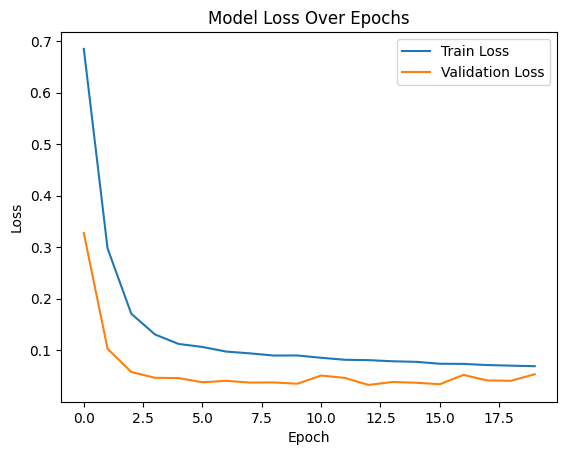

Enhanced model saved successfully.


In [58]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
np.random.seed(42)
tf.random.set_seed(42)


X_train, X_test, y_train, y_test = train_test_split(np_combined_vectors, labels, test_size=0.30, random_state=42)



model = Sequential([
    Dense(256, input_shape=(X_train.shape[1],)),
    LeakyReLU(alpha=0.01),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128),
    LeakyReLU(alpha=0.01),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64),
    LeakyReLU(alpha=0.01),
    BatchNormalization(),
    Dropout(0.4),
    Dense(32),
    LeakyReLU(alpha=0.01),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])


model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=40, batch_size=32,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping],
                    verbose=1)


test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"\nTest Accuracy: {test_acc}")

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()


model.save('nn_model_enhanced.keras')
print("Enhanced model saved successfully.")
